# Analysis of String Arrays

Particularly when it comes to the meta analysis of datasets within `turbopanda`, much of the intelligence comes down to *intuitive sorting* or *grouping* of features. One of the most sensible ways to do this is by looking at the similarities between the **column names**.

In [1]:
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0,"../")
# our main import
import turbopanda as turb

print("turbopanda: %s" % turb.__version__)

turbopanda version: 0.2.4


## Levenshtein distance

Levenshtein distance is a formal way of measuring the *distance* between two strings, $a$ and $b$. Mathematically described it does:

\begin{align}
\text{lev}_{a,b}(i, j)=\begin{cases}
\max{(i, j)} & \min{(i, j)=0} \\
\min{\begin{cases}
\text{lev}_{a,b}(i-1,j)+1 \\ \text{lev}_{a,b}(i,j-1)+1 \\ \text{lev}_{a,b}(i-1,j-1)+1_{(a_i\neq b_j)}
\end{cases}} & \text{otherwise}
\end{cases}
\end{align}

thus $\text{lev}_{a,b}(i, j)$ is the distance between the first $i$ characters of $a$ and the first $j$ characters of $b$; $i, j$ are 1-based indices. Note that this is a recursive algorithm and thus expensive for cases where $a$, $b$ have high $N$.

#### New in 0.2.4: Levenshtein distance is now Numba-supported

This means that CPU execution speeds for expensive Levenshtein calculations are now substantially faster.

## Example: Heterogenous biological replicates

Let's say you have a dataset representing the experiments from two replicate groups; let's say we have some mouse samples and human samples:

In [2]:

sx = ['rna_human_rep%d' % i for i in range(4)]
sy = ["rna_mouse_rep%d" % i for i in range(6)]
samples = sx + sy 
print(samples)

['rna_human_rep0', 'rna_human_rep1', 'rna_human_rep2', 'rna_human_rep3', 'rna_mouse_rep0', 'rna_mouse_rep1', 'rna_mouse_rep2', 'rna_mouse_rep3', 'rna_mouse_rep4', 'rna_mouse_rep5']


We can clearly see there is a distinguishable pattern in terms of the text names used here; let's see how `levenshtein` fares:

In [6]:
lev_m = turb.str.levenshtein(samples, as_matrix=True)

In [7]:
lev_m

y,rna_human_rep0,rna_human_rep1,rna_human_rep2,rna_human_rep3,rna_mouse_rep0,rna_mouse_rep1,rna_mouse_rep2,rna_mouse_rep3,rna_mouse_rep4,rna_mouse_rep5
x,,,,,,,,,,
rna_human_rep0,1.000000,0.928571,0.928571,0.928571,0.714286,0.642857,0.642857,0.642857,0.642857,0.642857
rna_human_rep1,0.928571,1.000000,0.928571,0.928571,0.642857,0.714286,0.642857,0.642857,0.642857,0.642857
rna_human_rep2,0.928571,0.928571,1.000000,0.928571,0.642857,0.642857,0.714286,0.642857,0.642857,0.642857
rna_human_rep3,0.928571,0.928571,0.928571,1.000000,0.642857,0.642857,0.642857,0.714286,0.642857,0.642857
rna_mouse_rep0,0.714286,0.642857,0.642857,0.642857,1.000000,0.928571,0.928571,0.928571,0.928571,0.928571
rna_mouse_rep1,0.642857,0.714286,0.642857,0.642857,0.928571,1.000000,0.928571,0.928571,0.928571,0.928571
rna_mouse_rep2,0.642857,0.642857,0.714286,0.642857,0.928571,0.928571,1.000000,0.928571,0.928571,0.928571
rna_mouse_rep3,0.642857,0.642857,0.642857,0.714286,0.928571,0.928571,0.928571,1.000000,0.928571,0.928571
rna_mouse_rep4,0.642857,0.642857,0.642857,0.642857,0.928571,0.928571,0.928571,0.928571,1.000000,0.928571


The function `levenshtein` returns essentially a distance *matrix* between every pairing of words.

A heatmap may more clearly highlight the relationship between the groups.

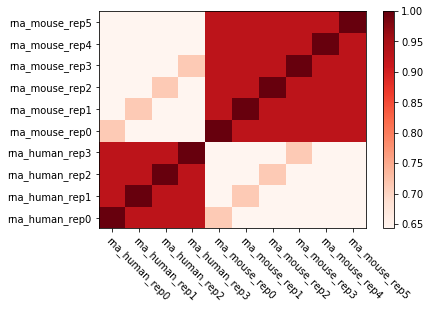

In [8]:
plt.pcolormesh(lev_m, cmap="Reds")
plt.xticks(ticks=np.arange(.5,len(lev_m)), labels=lev_m.columns, rotation=-45, ha='left', rotation_mode='anchor')
plt.yticks(ticks=np.arange(.5, len(lev_m)), labels=lev_m.columns)
plt.colorbar()
plt.show()

### Using clustering to find subgroups

The levenshtein distance matrix can be hierarchically clustered to find an optimal number of appropriate subgroups.

In [9]:
from scipy.cluster import hierarchy

In [10]:
hierarchy.fclusterdata(lev_m.values, 2, criterion='maxclust', method='average')

array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1], dtype=int32)

## Longest common substring matching

This is a well defined and known problem, whereby we wish to find the most likely common substring match between two strings $a$ and $b$.

Take the above example for biological replicates, between two mouse samples we would have:

In [11]:
turb.str.common_substrings(["rna_mouse_rep0", 'rna_mouse_rep3'])

'rna_mouse_rep'

Or between human and mouse:

In [12]:
turb.str.common_substrings(["rna_human_rep0", 'rna_mouse_rep3'])

'rna_'

Once again, we can compare the pairwise interactions between our dataset columns:

In [13]:
pairs = turb.str.common_substrings(samples)

In [14]:
pairs

rna_             20
rna_mouse_rep    15
rna_human_rep     6
dtype: int64